<a href="https://colab.research.google.com/github/tbradshaw91/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Bicycle_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading the data**

In [16]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1616k    0 1616k    0     0  1070k      0 --:--:--  0:00:01 --:--:-- 1069k


In [17]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-05-15 22:15:45--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv.2’

BicycleWeather.csv. 100%[===================>] 229.44K  --.-KB/s    in 0.05s   

2019-05-15 22:15:45 (4.50 MB/s) - ‘BicycleWeather.csv.2’ saved [234945/234945]



### **Loading the data from Monday's Assignment**

**Libraries for the data Pt.1**

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

# Download and join data into a dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

**Splitting Train and Test**

In [0]:
# Everything except the last 100 days
train = daily[:-100]
# The last 100 days
test = daily[-100:]
# Train features
X_train = train.drop(columns='Total')
y_train = train.Total
# Test features
X_test  = test.drop(columns='Total')
y_test  = test.Total

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # Use can vary on a day to day basis
    # Adding binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)

    # Riders may behave differently on holidays
    # Adding an indicator of this:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)

    # Hours of daylight may also have an affect 
    # How many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # Temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # Precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X
 

In [0]:
def wrangle(X):
  X = X.copy()
  X['no_snow'] = (X['SNWD']==0).astype(int)
  X['cold_asf'] = (X['TMAX'] <= 11).astype(int)
  X['cold_and_raining'] = ((X['TMAX'] <= 11) & ((X['dry day']==0) | (X['no_snow']==0))).astype(int)
  X['SNOW'] = X['SNOW'].replace({-9999:0})
  X['hot_asf'] = X['TMAX'] >= 29
  return X

# Splitting wrangle to X_train and X_test

X_train = wrangle(jake_wrangle(X_train))
X_test = wrangle(jake_wrangle(X_test))

##ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

*   Feature Importances
*   Permutation Importances
*   Partial Dependence Plot
*   Shapley Values

**Libraries Pt.2**

In [0]:
import eli5

In [0]:
!pip install shap

In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

**Feature Importances**

In [0]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

In [30]:
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 4)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state = 42),
    param_distributions=param_distributions,
    n_iter=2,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=2,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.3s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f78cdd4fef0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f78cdd5a080>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [31]:
print('Cross-Validation MAE:', search.best_score_)

Cross-Validation MAE: -325.45094956886237


In [0]:
best = search.best_estimator_

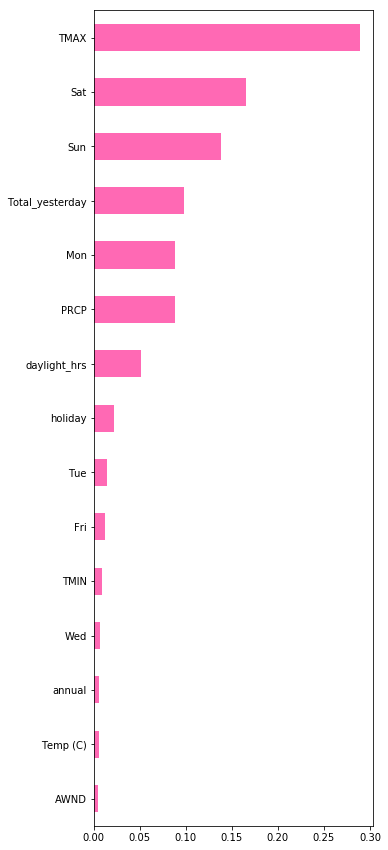

In [33]:
# Could do it n = len
#n = len(X_train.columns)
# For the sake of visuals
n = 15
figsize = (5,15)

importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='hotpink');

**Permutation Importances**


In [34]:
permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', 
                                 cv='prefit', n_iter = 2, random_state=42)

permuter.fit(X_train.values, y_train)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=229, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [35]:
# Figure out how to change the color
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
385.5527 ± 41.3640,TMAX
270.1361 ± 4.4761,Sat
207.1668 ± 7.5984,Total_yesterday
193.3028 ± 1.6584,Sun
176.3318 ± 13.6165,PRCP
104.2719 ± 7.0734,daylight_hrs
61.7861 ± 6.0418,Mon
52.0104 ± 4.5106,TMIN
29.1043 ± 0.9914,holiday
19.2254 ± 2.2503,Tue


**Partial Dependance Plot**

In [36]:
X_train.columns

Index(['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'no_snow', 'cold_asf',
       'cold_and_raining', 'hot_asf'],
      dtype='object')

In [37]:
mask = permuter.feature_importances_>0
features = X_train.columns[mask]
X_train_pdp = X_train[features]
X_test_pdp = X_test[features]

param_distributions = {
    'n_estimators' : [100, 200, 500],
    'max_depth': [2,3,5,10,50]
}

search = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions= param_distributions,
    n_iter=8,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_pdp, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=8, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 500], 'max_depth': [2, 3, 5, 10, 50]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [0]:
best = search.best_estimator_

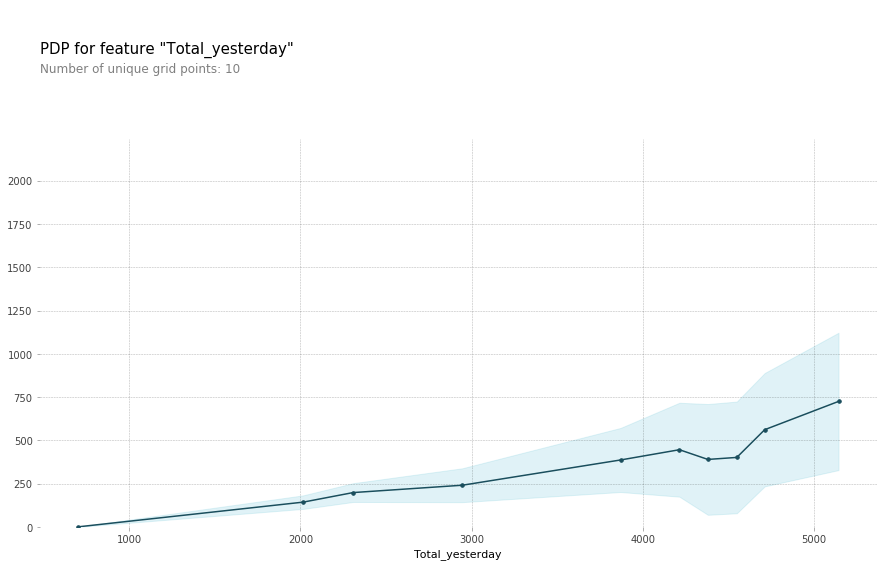

In [39]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Total_yesterday'
model_features = top_n.keys().tolist()

isolated = pdp_isolate(
    model=best,
    dataset=X_test_pdp,
    model_features=features,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [43]:
X_test_pdp.columns

Index(['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday',
       'Mon', 'Tue', 'Wed', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs',
       'Temp (C)', 'annual'],
      dtype='object')

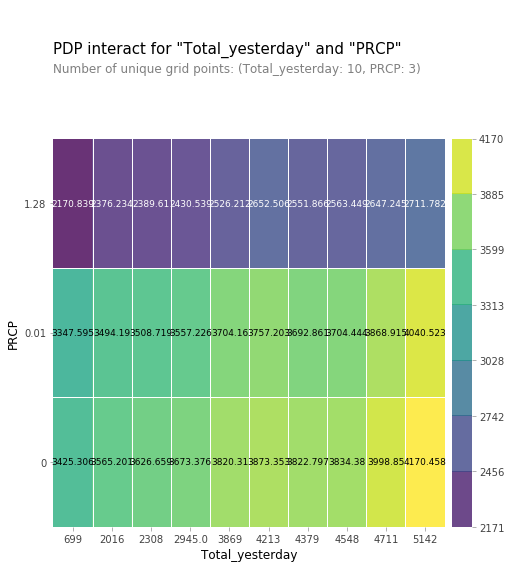

In [51]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Total_yesterday', 'PRCP']

interaction = pdp_interact(
    model=best,
    dataset=X_test_pdp,
    model_features=X_test_pdp.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

**Shapley Values**

In [68]:
data_for_prediction_data = X_test_pdp.sample(1)
print(data_for_prediction)

                PRCP  SNOW  SNWD  ...  daylight_hrs  Temp (C)    annual
2015-08-28  0.019685     0     0  ...     13.418591     19.45  0.260274

[1 rows x 17 columns]


In [69]:
shap.initjs()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)